In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import eda_helper_functions
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

import warnings

### 1.DISPLAY SETTINGS 

In [3]:
pd.set_option("display.max_columns",None)

In [5]:
sklearn.set_config(transform_output="pandas")

In [7]:
warnings.filterwarnings("ignore")

### 2.ACCESSING THE DATA FROM DATABASE.

In [9]:
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

In [11]:
import psycopg2
hostname = 'localhost'
database = 'nyfd'
user_name ='postgres'
pwd ='raksha'
port_id = 5432
conn =None
cur =None

In [13]:
engine = create_engine(f'postgresql://{user_name}:{pwd}@{hostname}:{port_id}/{database}')

In [15]:
sql = 'SELECT * FROM f_eng_col'

In [17]:
f_eng = pd.read_sql_query(sql,engine)

In [19]:
f_eng.sample(5)

,facility,date_of_inspection_transformed,violation_item,critical_violation,total_critical_violations,total_crit_not_corrected,total_noncritical_violations,local_health_department,permit_expiration_date,food_service_type,inspection_type
347685,BOUNTIFUL BREAD (STUYVESANT PLZ),2019-03-04,8A,Not Critical Violation,0.0,0.0,4.0,Albany County,1970-01-20 23:54:14.400,Food Service Establishment,Inspection
1213291,LOVIN' CUP,2012-03-26,15A,Not Critical Violation,2.0,0.0,10.0,Monroe County,1970-01-19 06:15:50.400,Food Service Establishment,Inspection
652936,American Legion-Bergen,2024-03-07,Nan,Not Critical Violation,0.0,0.0,0.0,Genesee County,1970-01-20 22:26:24.000,Food Service Establishment,Inspection
108586,MOSES TAYLOR POST #136,2021-09-28,12D,Not Critical Violation,0.0,0.0,5.0,Westchester County,1970-01-20 20:58:33.600,Food Service Establishment,Inspection
1003496,SYDA FOUNDATION ATMA NIDHI,2009-10-27,8D,Not Critical Violation,0.0,0.0,7.0,Middletown District Office,1970-01-21 02:06:43.200,Food Service Establishment,Inspection


In [21]:
f_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310734 entries, 0 to 1310733
Data columns (total 11 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   facility                        1310734 non-null  object        
 1   date_of_inspection_transformed  1310734 non-null  datetime64[ns]
 2   violation_item                  1310734 non-null  object        
 3   critical_violation              1310734 non-null  object        
 4   total_critical_violations       1310734 non-null  float64       
 5   total_crit_not_corrected        1310734 non-null  float64       
 6   total_noncritical_violations    1310734 non-null  float64       
 7   local_health_department         1310734 non-null  object        
 8   permit_expiration_date          1310734 non-null  datetime64[ns]
 9   food_service_type               1310734 non-null  object        
 10  inspection_type                 1310734 no

In [23]:
#creating a  function to not make any changes in original dataset
def feature_eng(data):
    return data.copy()


In [25]:
ff_eng = feature_eng(f_eng)

## 3.1 facility

In [23]:
ff_eng['facility'] = ff_eng.facility.str.upper()

In [27]:
ff_eng.facility.sample(5)

1044042           LITTLE CAESARS
847754     SUPER CREAM DAIRY BAR
892811        WINTER CLOVE, INC.
337230                KWONG MING
509757            ALL CITY GRILL
Name: facility, dtype: object

In [29]:
lowercase_present = ff_eng['facility'].str.contains('[a-z]').any()

print(lowercase_present)

False


In [31]:
lowercase_present = f_eng['facility'].str.contains('[a-z]').any()

print(lowercase_present)

True


- Dividing the `facility` into `categories`

In [267]:
import pandas as pd
from fuzzywuzzy import process, fuzz

# Define categories and keywords with expanded lists
categories = {
    'Fast Food': [
        'MCDONALDS', 'BURGER KING', 'TACO BELL', 'KFC', 'SUBWAY', 'DOMINOS', 
        'PIZZA HUT', 'POPEYES', 'CHICK-FIL-A', 'ARBY\'S', 'SONIC', 'DUNKIN', 
        'SHAKE SHACK', 'IN-N-OUT', 'FIVE GUYS', 'JACK IN THE BOX', 'FAST', 'FOOD', 
        'WENDYS', 'PIZZERIA', 'BURGER', 'SUBWAY', 'WOK', 'KING', 'CHICKEN'
    ],
    'Indian': [
        'INDIA', 'CURRY', 'MASALA', 'TANDOOR', 'BIRYANI', 'DAL', 'PANEER', 
        'CHAAT', 'DHABA', 'MUGHLAI', 'TIKKA', 'NAAN', 'DOSAS', 'SAMOSA', 
        'CHAAT HOUSE', 'TANDOORI', 'BOLLYWOOD', 'KABAB', 'BANGALORE', 'INDIAN', 
        'MAHAL'
    ],
    'Chinese': [
        'CHINA', 'DRAGON', 'WOK', 'DIM SUM', 'SZECHUAN', 'MANDARIN', 'PEKING', 
        'CHOPSTICK', 'HOT POT', 'HUNAN', 'GOLDEN', 'GARDEN', 'BAMBOO', 
        'LOTUS', 'PANDA', 'JADE', 'FORTUNE', 'DYNASTY', 'CHINESE', 'SHANGHAI'
    ],
    'Italian': [
        'PIZZA', 'PASTA', 'ITALIAN', 'RISTORANTE', 'TRATTORIA', 'OSTERIA', 
        'GELATO', 'PIZZERIA', 'SPAGHETTI', 'ALFREDO', 'CARBONARA', 'MARGHERITA', 
        'LASAGNA', 'BOLOGNESE', 'MAMMA', 'NAPOLI', 'ROMA', 'VENETIAN', 'ITALY'
    ],
    'Japanese': [
        'SUSHI', 'JAPAN', 'RAMEN', 'TERIYAKI', 'TEMPURA', 'UDON', 'KATSU', 
        'SASHIMI', 'TEPPANYAKI', 'IZAKAYA', 'SHABU-SHABU', 'YAKITORI', 
        'DONBURI', 'KAISEN', 'TONKATSU', 'MISO', 'KIMONO', 'KYOTO', 'JAPANESE'
    ],
    'Mexican': [
        'TACO', 'BURRITO', 'MEXICO', 'QUESADILLA', 'ENCHILADA', 'FAJITA', 
        'SALSA', 'GUACAMOLE', 'TEQUILA', 'CANTINA', 'BODEGA', 'TAQUERIA', 
        'HUEVOS', 'CHORIZO', 'MOLE', 'TAMALE', 'JALAPENO', 'TORTA', 'MEXICAN'
    ],
    'American': [
        'DINER', 'GRILL', 'BBQ', 'STEAKHOUSE', 'CAFÉ', 'BREWERY', 'PUB', 
        'BAR', 'BURGER', 'AMERICAN', 'ROADSIDE', 'ROUTE', 'SMOKEHOUSE', 
        'ROASTERY', 'TAVERN', 'HOUSE', 'BAR & GRILL', 'CHOPHOUSE', 'DELTA', 
        'STATE', 'WESTERN', 'AMERICAN', 'DELI', 'BURGER', 'GRILL', 'STEAKHOUSE', 'HOUSE'
    ],
    'Other': []
}

# Flatten the keyword list for fuzzy matching
all_keywords = [keyword for keywords in categories.values() for keyword in keywords]

# Function to categorize restaurant names with fuzzy matching
def categorize_restaurant_fuzzy(name):
    name = name.upper()
    best_match, score = process.extractOne(name, all_keywords, scorer=fuzz.partial_ratio)
    if score >= 80:  # Adjust the threshold as needed
        for category, keywords in categories.items():
            if best_match in keywords:
                return category
    return 'Other'

# Clean the data by converting all non-string values to empty strings
ff_eng['facility'] = ff_eng['facility'].fillna('').astype(str)

# Apply the fuzzy categorization function
ff_eng['restaurant_category'] = ff_eng['facility'].apply(categorize_restaurant_fuzzy)



In [269]:
ff_eng.restaurant_category.value_counts()

restaurant_category
Other        666483
American     247378
Fast Food    168427
Italian       82191
Chinese       62922
Mexican       30168
Indian        27902
Japanese      24016
Name: count, dtype: int64

In [271]:
eda_helper_functions.hyp_cat_cat(ff_eng,"restaurant_category","critical_violation")


- Cramers V            : 0.030735742503101834
- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 1244.0529228633825
- p-value              : 2.0990961129199734e-264
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables restaurant_category and critical_violation are correlated


In [43]:
eda_helper_functions.hyp_cat_cat(ff_eng,"facility","critical_violation")

- Cramers V            : 0.19374756216313033
- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 80966.474049964
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables facility and critical_violation are correlated


- `CORELATION` IS LOW ,SO, WE WILL IGNORE THIS COLUMN.

## 3.2 date of inspection 

- Creating new feature `days since last inspection`using date_of_inspection.

In [63]:
ff_eng.groupby('facility')['date_of_inspection_transformed'].value_counts() 

facility             date_of_inspection_transformed
#1 KING'S BUFFET, A  2006-06-03                        15
                     2018-03-21                        13
                     2008-11-04                        12
                     2019-06-03                        12
                     2009-09-03                        11
                                                       ..
ZUPPA                2014-11-13                         1
                     2015-05-20                         1
                     2015-06-24                         1
                     2019-10-01                         1
                     2019-10-31                         1
Name: count, Length: 530191, dtype: int64

In [27]:
ff_eng = ff_eng.sort_values(['facility','date_of_inspection_transformed'])
ff_eng['days_since_last_inspection']=ff_eng.groupby('facility')['date_of_inspection_transformed'].diff().dt.days
ff_eng['avg_days_bw_inspection'] = ff_eng.groupby('facility')['days_since_last_inspection'].transform('mean')

In [41]:
ff_eng.days_since_last_inspection.value_counts()

days_since_last_inspection
0.0       780543
1.0         3632
364.0       3396
7.0         3307
365.0       2984
           ...  
2182.0         1
1648.0         1
3648.0         1
1789.0         1
2597.0         1
Name: count, Length: 2449, dtype: int64

In [63]:
ff_eng.avg_days_bw_inspection.value_counts()

avg_days_bw_inspection
1.207549       8134
0.000000       4474
4.320889       2251
6.243280       1489
5.183119       1399
               ... 
557.000000        2
578.000000        2
2631.000000       2
249.000000        2
1324.000000       2
Name: count, Length: 24045, dtype: int64

In [29]:
ff_eng.avg_days_bw_inspection.isna().sum()

1247

In [29]:
ff_eng  = ff_eng.dropna(subset=['avg_days_bw_inspection'])

In [31]:
ff_eng.avg_days_bw_inspection.isna().sum()

0

In [39]:
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import LabelEncoder

def mutual_information(categorical, numerical):
    le = LabelEncoder()
    cat_encoded = le.fit_transform(categorical)
    mi_score = mutual_info_score(cat_encoded, numerical)
    return mi_score

mi = mutual_information(ff_eng['critical_violation'], ff_eng['avg_days_bw_inspection'])
print(f"Mutual Information Score: {mi}")

Mutual Information Score: 0.0290678849267348


6.181358965958273

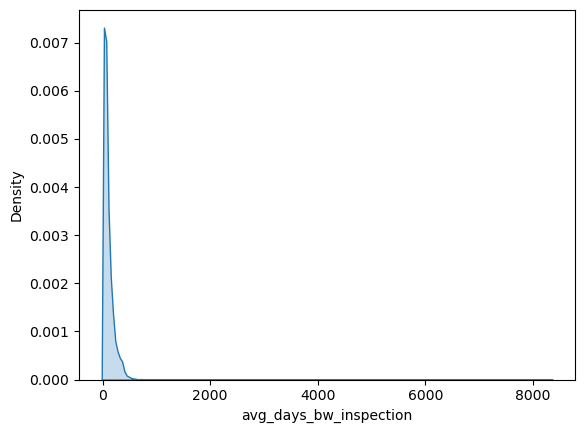

In [41]:
sns.kdeplot(ff_eng['avg_days_bw_inspection'],shade=True)
ff_eng['avg_days_bw_inspection'].skew()

- It is right skewed , lets apply `log transformation` 

<Axes: xlabel='sqrt_avg_days', ylabel='Density'>

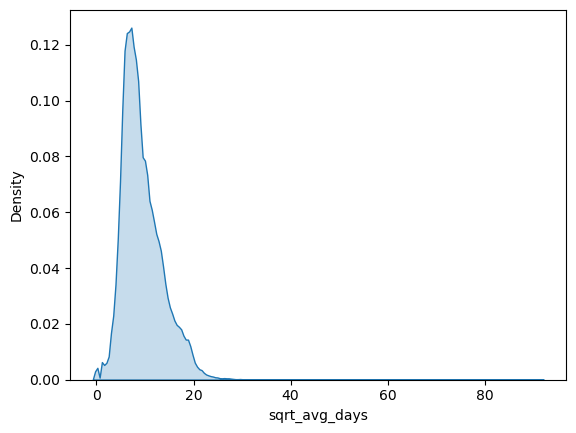

In [33]:
ff_eng ['sqrt_avg_days'] = np.sqrt(ff_eng['avg_days_bw_inspection'])
sns.kdeplot(ff_eng ['sqrt_avg_days'],shade=True)

In [91]:
ff_eng ['sqrt_avg_days'].skew()

1.0772029430173335

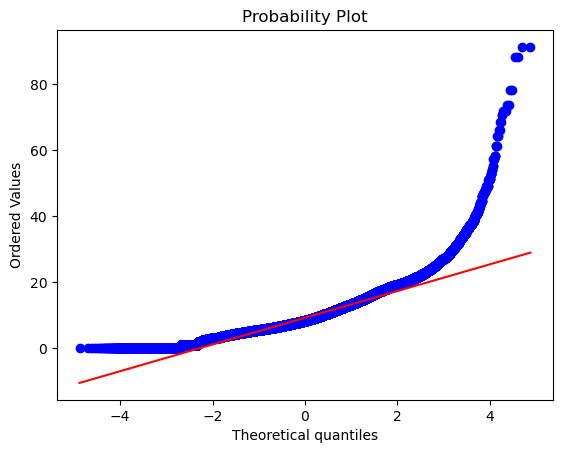

Reject null hypothesis: Data is not normally distributed.
Reject null hypothesis: Data is not normally distributed.
Shapiro-Wilk Test Results:
W: 0.942959521350369
p-value: 2.1970668771657995e-139
Reject null hypothesis: Data is not normally distributed.
Anderson-Darling Test Results:
A2: 19962.360864687478
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Level: [15.  10.   5.   2.5  1. ]
Reject null hypothesis: Data is not normally distributed.


In [93]:
from scipy import stats
stats.probplot(ff_eng['sqrt_avg_days'], dist='norm', plot=plt)
plt.show()
ks_stat, ks_p = stats.kstest(ff_eng['sqrt_avg_days'], 'norm')

if ks_p < 0.05:
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data is normally distributed.")
normal_stat, normal_p = stats.normaltest(ff_eng['sqrt_avg_days'])

if normal_p < 0.05:
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data is normally distributed.")


W, p_value = stats.shapiro(ff_eng['sqrt_avg_days'])

print("Shapiro-Wilk Test Results:")
print("W:", W)
print("p-value:", p_value)

if p_value < 0.05:
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data is normally distributed.")


A2, critical_values, significance_level = stats.anderson(ff_eng['sqrt_avg_days'])

print("Anderson-Darling Test Results:")
print("A2:", A2)
print("Critical Values:", critical_values)
print("Significance Level:", significance_level)

if A2 > critical_values[4]:
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data is normally distributed.")

- We can see that curve got fixed and became almost normal.

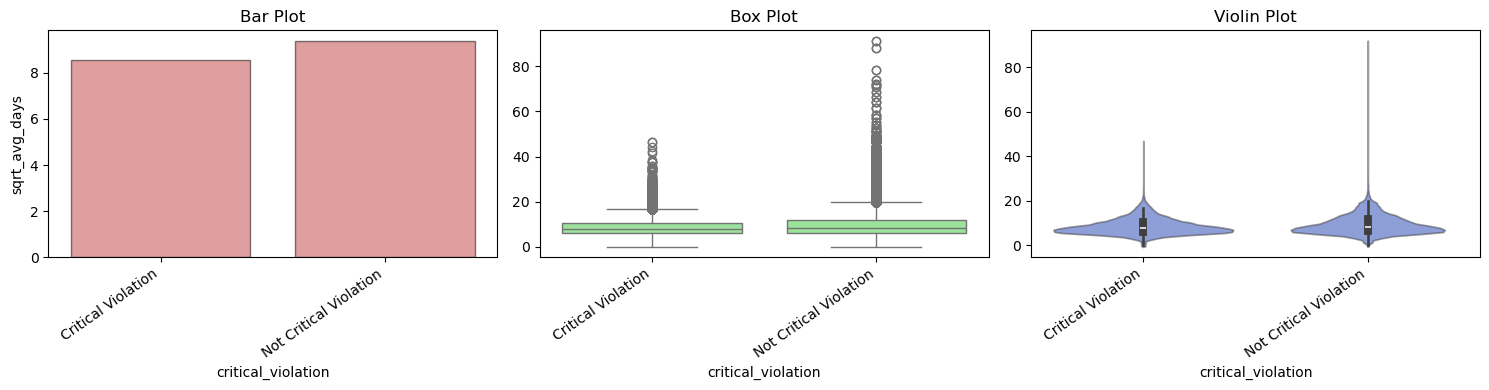

In [95]:
eda_helper_functions.num_cat_bivar_plots(ff_eng,"sqrt_avg_days","critical_violation")

- `days since last inspection` is also contributing less predicting the `critical_violation`

In [35]:
avg_days_since_pipe = Pipeline(
    steps=[
        ('scaler',StandardScaler())
    ]
)
avg_days_since_pipe.fit_transform(ff_eng[['sqrt_avg_days']])

,sqrt_avg_days
485994,-0.910873
791441,-0.910873
625,-0.910873
5684,-0.910873
171324,-0.910873
...,...
149299,0.451807
877108,0.451807
1069297,0.451807
484407,0.451807


## 3.3 Violation item

In [99]:
eda_helper_functions.cat_summary(ff_eng, "violation_item")

485994     Nan
791441     Nan
625        Nan
5684       Nan
171324     Nan
          ... 
468718     11C
779662      8A
1091655    11D
1255155    10A
1262668    11A
Name: violation_item, Length: 1309487, dtype: object

Data Type      : object
Cardinality    : 99 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 1,309,487 / 1,309,487 rows


,
count,1309487
unique,99
top,Nan
freq,240271


,count,percentage
category,,
Nan,240271,1.834848e-01
15A,110123,8.409629e-02
8A,98203,7.499349e-02
10B,78036,5.959280e-02
11D,77741,5.936752e-02
15B,68589,5.237853e-02
12E,54393,4.153764e-02
8E,40503,3.093043e-02
12C,39968,3.052188e-02


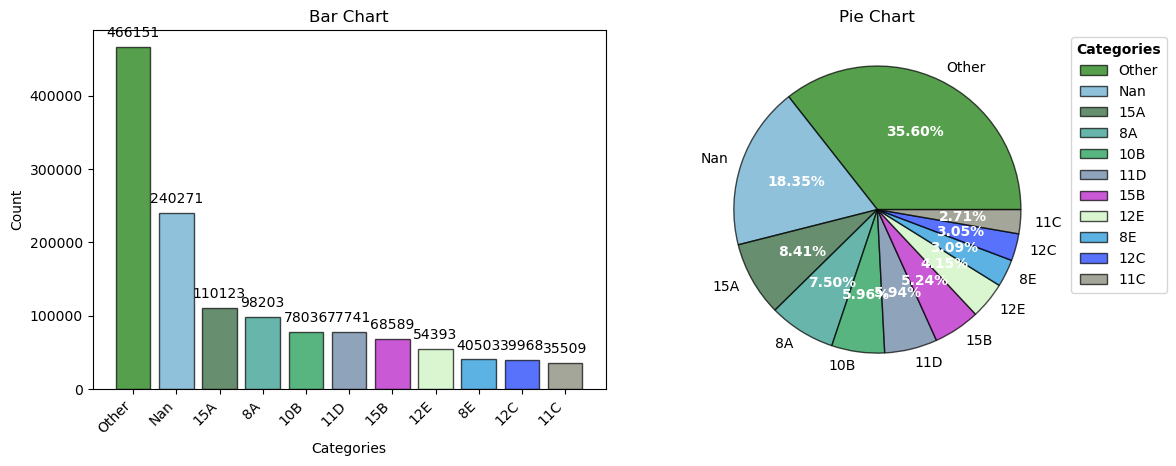

In [101]:
eda_helper_functions.cat_univar_plots(ff_eng, "violation_item", show_wordcloud=False,k=10)


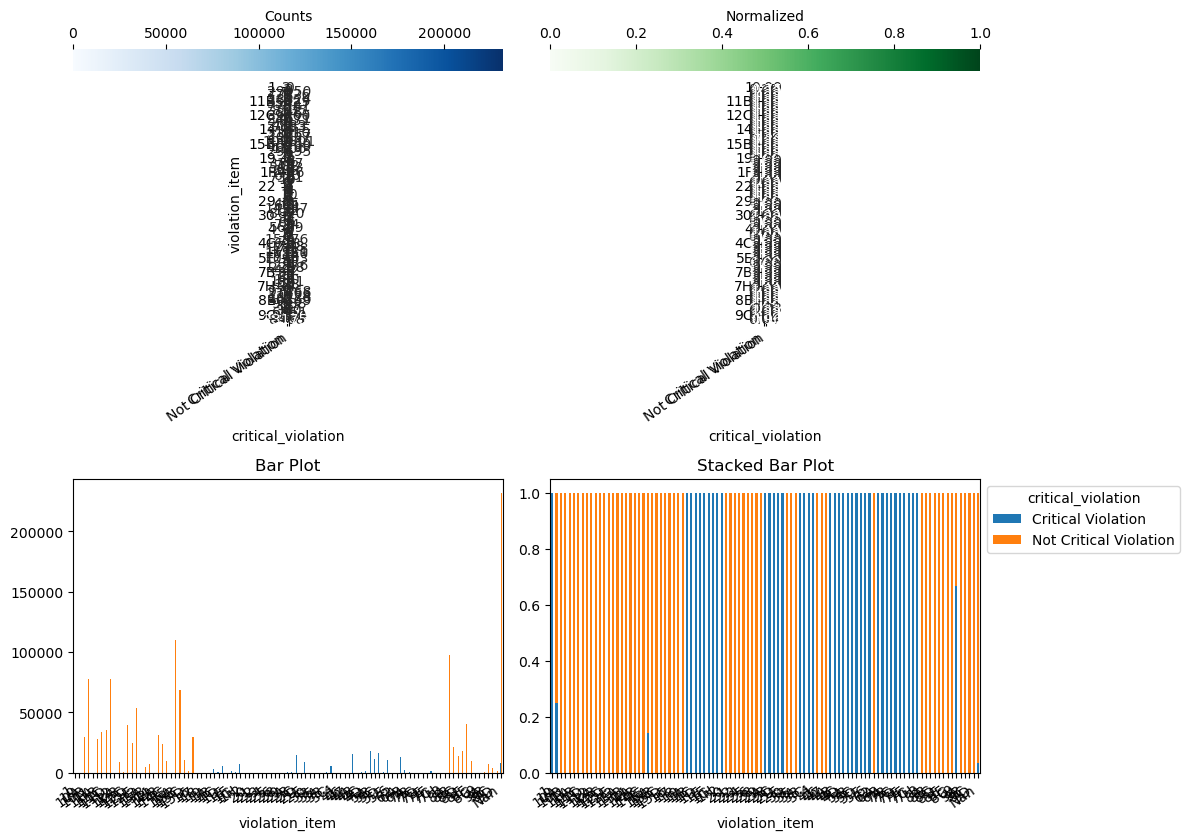

In [131]:
eda_helper_functions.cat_bivar_plots(ff_eng,"violation_item","critical_violation")

In [103]:
eda_helper_functions.hyp_cat_cat(ff_eng,"violation_item","critical_violation")

- Cramers V            : 0.9691667286876327
- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 1230077.4418956162
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables violation_item and critical_violation are correlated


- We can see there is `strong corelation` b/w violation item and target column.

In [37]:
violation_code_pipe = Pipeline(
    steps=[
        ('ohe',OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)
violation_code_pipe.fit_transform(ff_eng[['violation_item']])

,violation_item_1,violation_item_10,violation_item_10A,violation_item_10B,violation_item_11,violation_item_11A,violation_item_11B,violation_item_11C,violation_item_11D,violation_item_12,violation_item_12A,violation_item_12B,violation_item_12C,violation_item_12D,violation_item_12E,violation_item_13,violation_item_13A,violation_item_13B,violation_item_14,violation_item_14A,violation_item_14B,violation_item_14C,violation_item_15,violation_item_15A,violation_item_15B,violation_item_15C,violation_item_15D,violation_item_16,violation_item_17,violation_item_18,violation_item_19,violation_item_1A,violation_item_1B,violation_item_1C,violation_item_1D,violation_item_1E,violation_item_1F,violation_item_1G,violation_item_1H,violation_item_2,violation_item_20,violation_item_21,violation_item_22,violation_item_23,violation_item_24,violation_item_25,violation_item_26,violation_item_28,violation_item_29,violation_item_2A,violation_item_2B,violation_item_2C,violation_item_2D,violation_item_2E,violation_item_30,violation_item_33,violation_item_35,violation_item_3A,violation_item_3B,violation_item_3C,violation_item_4,violation_item_41,violation_item_46,violation_item_47,violation_item_4A,violation_item_4B,violation_item_4C,violation_item_4D,violation_item_5A,violation_item_5B,violation_item_5C,violation_item_5D,violation_item_5E,violation_item_6,violation_item_62,violation_item_6A,violation_item_6B,violation_item_7A,violation_item_7B,violation_item_7C,violation_item_7D,violation_item_7E,violation_item_7F,violation_item_7G,violation_item_7H,violation_item_8,violation_item_8A,violation_item_8B,violation_item_8C,violation_item_8D,violation_item_8E,violation_item_8F,violation_item_8G,violation_item_9,violation_item_9A,violation_item_9B,violation_item_9C,violation_item_9D,violation_item_Nan
485994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
791441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
171324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

## 3.4 local health department

In [107]:
eda_helper_functions.hyp_cat_cat(ff_eng,"local_health_department","critical_violation")


- Cramers V            : 0.10123272354571052
- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 13463.696783126223
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables local_health_department and critical_violation are correlated


## 3.4 Permit expiration date

In [39]:
from datetime import datetime
ff_eng['permit_expiration_days'] = (pd.Timestamp(datetime.now()) - ff_eng['permit_expiration_date']).dt.days
eda_helper_functions.num_cat_hyp_testing(ff_eng,"permit_expiration_days","critical_violation")


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 235.29660911166738
- p-value              : 4.2162378698536955e-53
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables permit_expiration_days and critical_violation are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 417.6635466695102
- p-value              : 7.87057212080301e-93
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables permit_expiration_days and critical_violation are associated to each other


In [111]:
from sklearn.metrics import mutual_info_score
mi = mutual_info_score(ff_eng['critical_violation'], ff_eng['permit_expiration_days'])
print("Mutual Information:", mi)

Mutual Information: 0.00033160757108182054


8.968678804131363

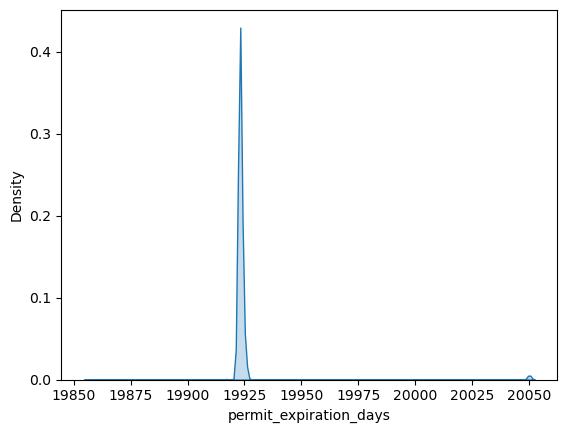

In [113]:
sns.kdeplot(ff_eng['permit_expiration_days'],shade=True)
ff_eng['permit_expiration_days'].skew()

<Axes: xlabel='sqrt_permit_days', ylabel='Density'>

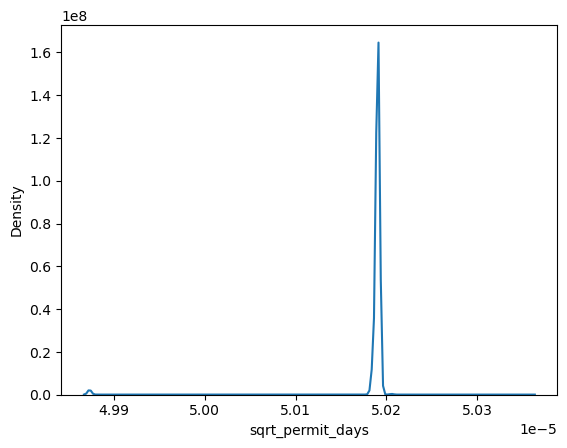

In [41]:
ff_eng ['sqrt_permit_days'] = np.divide(1,ff_eng['permit_expiration_days'])
sns.kdeplot(ff_eng['sqrt_permit_days'])

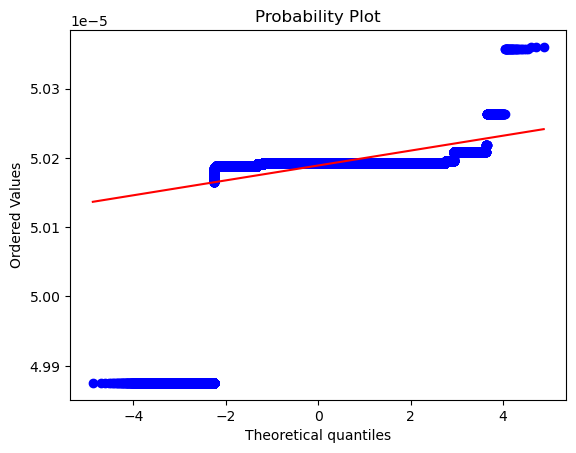

Reject null hypothesis: Data is not normally distributed.


In [129]:
stats.probplot(ff_eng['sqrt_permit_days'], dist='norm', plot=plt)
plt.show()
anderson_stat, anderson_crit, anderson_sig = stats.anderson(ff_eng['sqrt_permit_days'])
if anderson_stat > anderson_crit[2]:
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data is normally distributed")

In [43]:
ff_eng['sqrt_permit_days'].skew()

0.0

In [133]:
import scipy.stats as stats
mutual_info_score(ff_eng['critical_violation'], ff_eng['sqrt_permit_days'])
spearman_corr = stats.spearmanr(ff_eng['sqrt_permit_days'], ff_eng['critical_violation'])

print("Spearman Rank Correlation:", spearman_corr.correlation)
print("p-value:", spearman_corr.pvalue)

Spearman Rank Correlation: -0.01790208819489252
p-value: 2.784014587178802e-93


In [135]:
mutual_info_score(ff_eng['critical_violation'], ff_eng['sqrt_permit_days'])

0.0003316075710818205

In [43]:
permit_date_pipeline = Pipeline(
    steps=[
        ('scaler',MinMaxScaler())
    ]
)
permit_date_pipeline.fit_transform(ff_eng.loc[:, ["sqrt_permit_days"]])

,sqrt_permit_days
485994,0.655851
791441,0.655851
625,0.655851
5684,0.655851
171324,0.655851
...,...
149299,0.655851
877108,0.655851
1069297,0.655851
484407,0.655851


## 3.5 ALL CRITICAL VIOLATIONS

In [45]:
vio_info_cols=ff_eng[['total_critical_violations',
       'total_crit_not_corrected', 'total_noncritical_violations']]


In [193]:
mi_x = mutual_info_score(ff_eng['critical_violation'], ff_eng['total_critical_violations'])
print("Mutual Information:", mi_x)


Mutual Information: 0.11421590489840057


3.6885990801089648

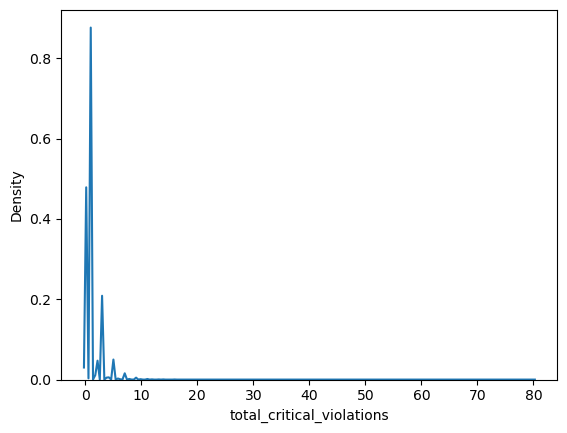

In [195]:
sns.kdeplot(ff_eng['total_critical_violations'])
ff_eng['total_critical_violations'].skew()

In [47]:
ff_eng['cbrt_crit_vio']=np.cbrt(ff_eng['total_critical_violations'])
ff_eng['cbrt_crit_vio'].skew()

0.5429522535183895

<Axes: xlabel='cbrt_crit_vio', ylabel='Density'>

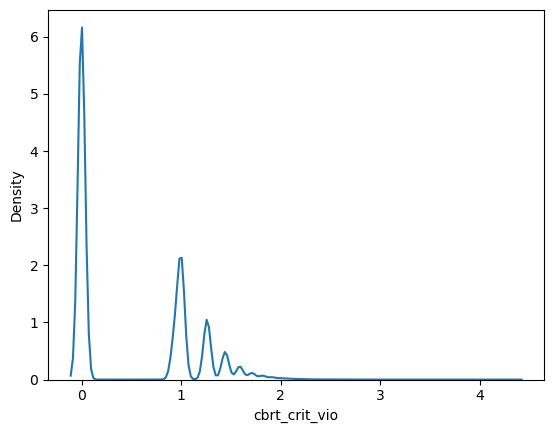

In [199]:
sns.kdeplot(ff_eng['cbrt_crit_vio'])

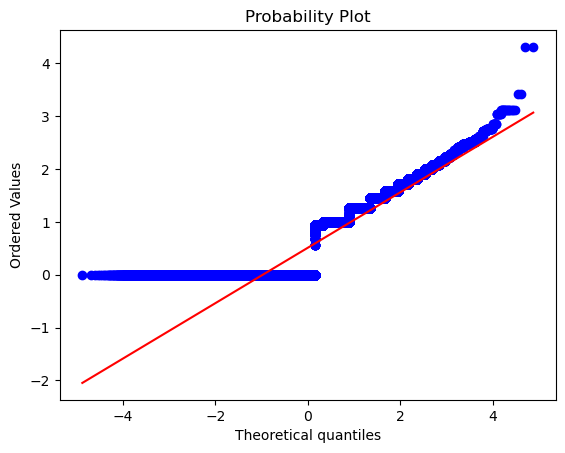

Reject null hypothesis: Data is not normally distributed.
Reject null hypothesis: Data is not normally distributed.


In [201]:
stats.probplot(ff_eng['cbrt_crit_vio'], dist='norm', plot=plt)
plt.show()
anderson_stat, anderson_crit, anderson_sig = stats.anderson(ff_eng['cbrt_crit_vio'])
if anderson_stat > anderson_crit[2]:
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data is normally distributed")
normal_stat, normal_p = stats.normaltest(ff_eng['cbrt_crit_vio'])

if normal_p < 0.05:
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data is normally distributed.")

- Transfomation led `total critical violations` to  `normal distribution`.

In [203]:

mutual_info_score(ff_eng['critical_violation'], ff_eng['cbrt_crit_vio'])


0.11421590489840057

In [205]:
mi_y = mutual_info_score(ff_eng['critical_violation'], ff_eng['total_crit_not_corrected'])
print("Mutual Information:", mi_y)

Mutual Information: 0.0027715461461021375


101.95873467125077

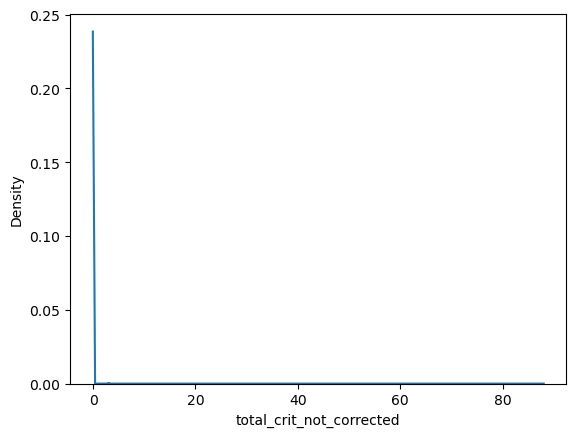

In [51]:
sns.kdeplot(ff_eng['total_crit_not_corrected'])
ff_eng['total_crit_not_corrected'].skew()

In [49]:
ff_eng['cbrt_crit_not_corrected']=np.cbrt(ff_eng['total_crit_not_corrected'])
ff_eng['cbrt_crit_not_corrected'].skew()

5.5148938786036075

<Axes: xlabel='cbrt_crit_not_corrected', ylabel='Density'>

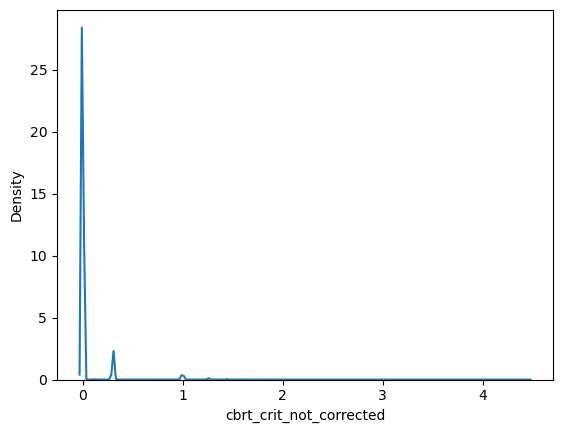

In [215]:
sns.kdeplot(ff_eng['cbrt_crit_not_corrected'])

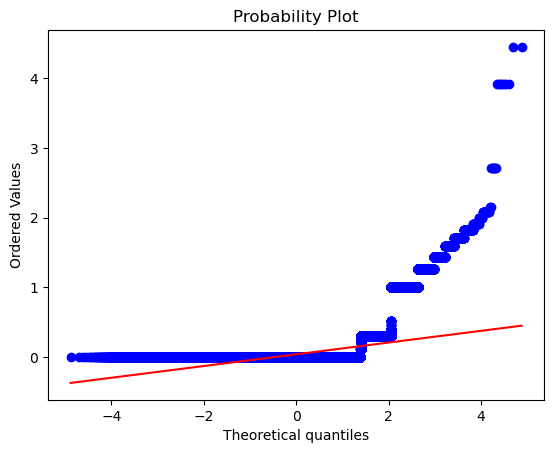

Reject null hypothesis: Data is not normally distributed.
Reject null hypothesis: Data is not normally distributed.


In [217]:
stats.probplot(ff_eng['cbrt_crit_not_corrected'], dist='norm', plot=plt)
plt.show()
anderson_stat, anderson_crit, anderson_sig = stats.anderson(ff_eng['cbrt_crit_not_corrected'])
if anderson_stat > anderson_crit[2]:
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data is normally distributed")
normal_stat, normal_p = stats.normaltest(ff_eng['cbrt_crit_not_corrected'])

if normal_p < 0.05:
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data is normally distributed.")

In [219]:
mutual_info_score(ff_eng['critical_violation'], ff_eng['cbrt_crit_not_corrected'])

0.0027715461461021375

In [221]:
mi_z = mutual_info_score(ff_eng['critical_violation'], ff_eng['total_noncritical_violations'])
print("Mutual Information:", mi_z)

Mutual Information: 0.0018088971192513


2.5515610524142516

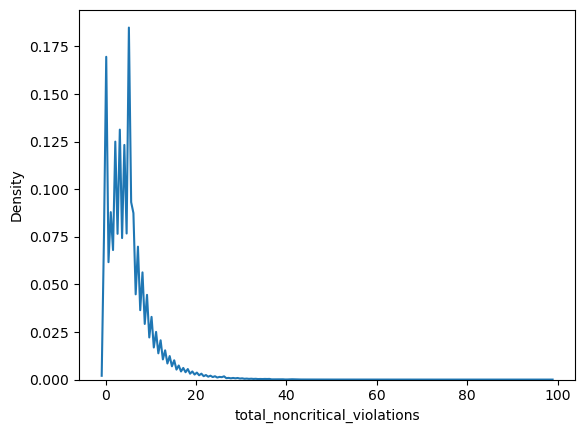

In [223]:
sns.kdeplot(ff_eng['total_noncritical_violations'])
ff_eng['total_noncritical_violations'].skew()

In [51]:
ff_eng['sqrt_noncrit'] = np.sqrt(ff_eng['total_noncritical_violations'])
ff_eng['sqrt_noncrit'].skew()

0.07184934908197863

<Axes: xlabel='sqrt_noncrit', ylabel='Density'>

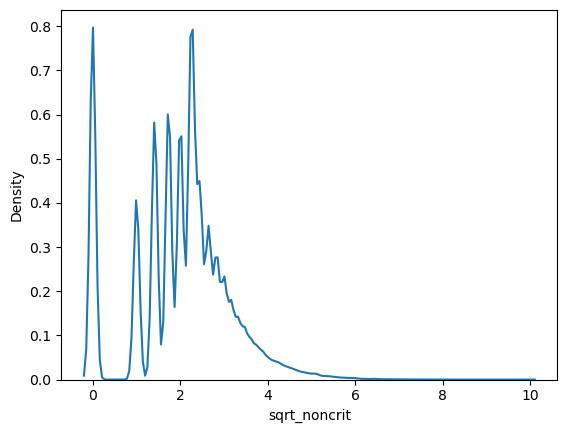

In [239]:
sns.kdeplot(ff_eng['sqrt_noncrit'])

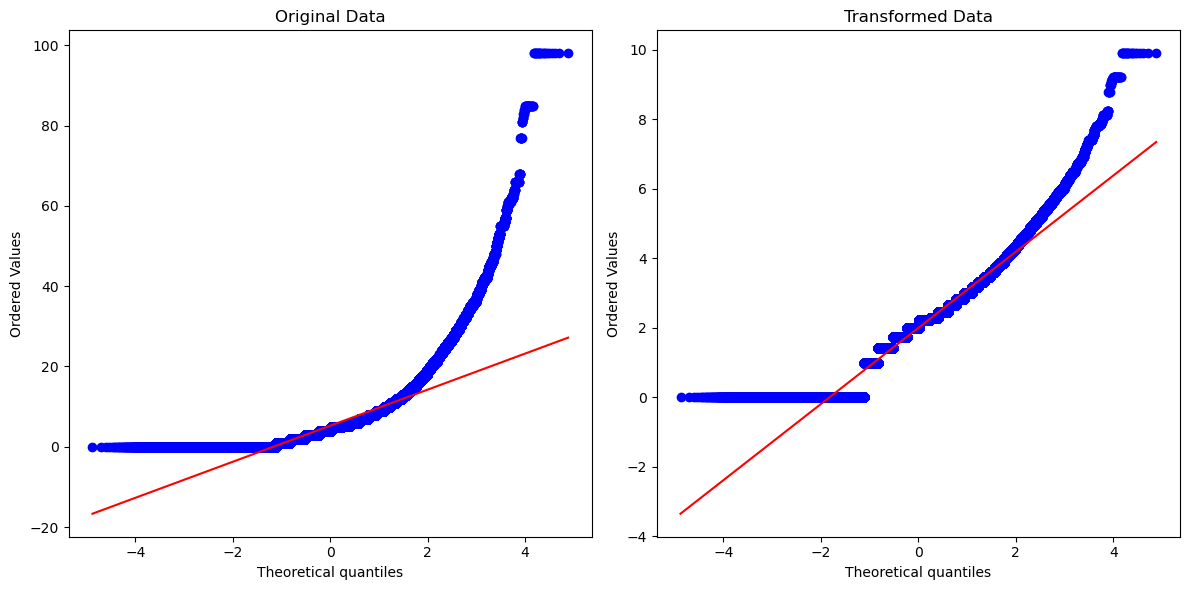

In [255]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
stats.probplot(ff_eng['total_noncritical_violations'], dist='norm', plot=ax[0])
ax[0].set_title('Original Data')
stats.probplot(ff_eng['sqrt_noncrit'], dist='norm', plot=ax[1])
ax[1].set_title('Transformed Data')
fig.tight_layout()
plt.show()

In [253]:

anderson_stat, anderson_crit, anderson_sig = stats.anderson(ff_eng['sqrt_noncrit'])
if anderson_stat > anderson_crit[2]:
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data is normally distributed")
normal_stat, normal_p = stats.normaltest(ff_eng['sqrt_noncrit'])

if normal_p < 0.05:
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data is normally distributed.")

Reject null hypothesis: Data is not normally distributed.
Reject null hypothesis: Data is not normally distributed.


In [243]:
mutual_info_score(ff_eng['critical_violation'], ff_eng['sqrt_noncrit'])

0.0018088971192513

In [53]:
vio_trans = ff_eng[['cbrt_crit_vio','cbrt_crit_not_corrected','sqrt_noncrit']]

In [55]:
vio_crit_pipe = Pipeline(
    steps=[
        ('scaler',StandardScaler())
    ]
)
vio_crit_pipe.fit_transform(vio_trans)

,cbrt_crit_vio,cbrt_crit_not_corrected,sqrt_noncrit
485994,0.699391,1.600161,0.260420
791441,0.699391,1.600161,0.260420
625,0.699391,1.600161,0.260420
5684,1.982422,-0.241631,-1.782461
171324,0.699391,1.600161,0.260420
...,...,...,...
149299,-0.842125,-0.241631,-1.782461
877108,0.809680,5.770517,-0.890950
1069297,0.809680,5.770517,-0.890950
484407,-0.842125,-0.241631,-1.782461


## 3.6 food service type and inspection type

In [243]:
ff_eng.food_service_type.value_counts()

food_service_type
Food Service Establishment    1131786
Institutional Food Service     154691
SED Summer Feeding Prog.        14210
SOFA Food Service               10047
Name: count, dtype: int64

In [259]:
eda_helper_functions.hyp_cat_cat(ff_eng,"food_service_type","critical_violation")

- Cramers V            : 0.030542246709071897
- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 1224.5263008591028
- p-value              : 3.497604071382158e-265
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables food_service_type and critical_violation are correlated


In [262]:
eda_helper_functions.hyp_cat_cat(ff_eng,"inspection_type","critical_violation")

- Cramers V            : 0.031143572365160962
- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 1271.0994113635536
- p-value              : 2.1566474234573934e-278
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables inspection_type and critical_violation are correlated


- so, we will not use `food service type` and `inspection type` because there `crammers v is too low.`

In [59]:
X = ff_eng[['sqrt_avg_days','violation_item','cbrt_crit_vio','cbrt_crit_not_corrected','sqrt_noncrit','sqrt_permit_days']]
y= ff_eng['critical_violation']

In [61]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


## Column transformer

In [63]:
column_transformer = ColumnTransformer(
    transformers=[
        ('avg days since last inspection',avg_days_since_pipe,['sqrt_avg_days']),
        ('violation item ',violation_code_pipe,['violation_item']),
        ('all violations transformed', vio_crit_pipe, ['cbrt_crit_vio','cbrt_crit_not_corrected','sqrt_noncrit']),
        ('permit days remaining',permit_date_pipeline,['sqrt_permit_days']) 
    ], remainder="passthrough"
)
trans_df = column_transformer.fit_transform(X,y_encoded)
trans_df

,avg days since last inspection__sqrt_avg_days,violation item __violation_item_1,violation item __violation_item_10,violation item __violation_item_10A,violation item __violation_item_10B,violation item __violation_item_11,violation item __violation_item_11A,violation item __violation_item_11B,violation item __violation_item_11C,violation item __violation_item_11D,violation item __violation_item_12,violation item __violation_item_12A,violation item __violation_item_12B,violation item __violation_item_12C,violation item __violation_item_12D,violation item __violation_item_12E,violation item __violation_item_13,violation item __violation_item_13A,violation item __violation_item_13B,violation item __violation_item_14,violation item __violation_item_14A,violation item __violation_item_14B,violation item __violation_item_14C,violation item __violation_item_15,violation item __violation_item_15A,violation item __violation_item_15B,violation item __violation_item_15C,violation item __violation_item_15D,violation item __violation_item_16,violation item __violation_item_17,violation item __violation_item_18,violation item __violation_item_19,violation item __violation_item_1A,violation item __violation_item_1B,violation item __violation_item_1C,violation item __violation_item_1D,violation item __violation_item_1E,violation item __violation_item_1F,violation item __violation_item_1G,violation item __violation_item_1H,violation item __violation_item_2,violation item __violation_item_20,violation item __violation_item_21,violation item __violation_item_22,violation item __violation_item_23,violation item __violation_item_24,violation item __violation_item_25,violation item __violation_item_26,violation item __violation_item_28,violation item __violation_item_29,violation item __violation_item_2A,violation item __violation_item_2B,violation item __violation_item_2C,violation item __violation_item_2D,violation item __violation_item_2E,violation item __violation_item_30,violation item __violation_item_33,violation item __violation_item_35,violation item __violation_item_3A,violation item __violation_item_3B,violation item __violation_item_3C,violation item __violation_item_4,violation item __violation_item_41,violation item __violation_item_46,violation item __violation_item_47,violation item __violation_item_4A,violation item __violation_item_4B,violation item __violation_item_4C,violation item __violation_item_4D,violation item __violation_item_5A,violation item __violation_item_5B,violation item __violation_item_5C,violation item __violation_item_5D,violation item __violation_item_5E,violation item __violation_item_6,violation item __violation_item_62,violation item __violation_item_6A,violation item __violation_item_6B,violation item __violation_item_7A,violation item __violation_item_7B,violation item __violation_item_7C,violation item __violation_item_7D,violation item __violation_item_7E,violation item __violation_item_7F,violation item __violation_item_7G,violation item __violation_item_7H,violation item __violation_item_8,violation item __violation_item_8A,violation item __violation_item_8B,violation item __violation_item_8C,violation item __violation_item_8D,violation item __violation_item_8E,violation item __violation_item_8F,violation item __violation_item_8G,violation item __violation_item_9,violation item __violation_item_9A,violation item __violation_item_9B,violation item __violation_item_9C,violation item __violation_item_9D,violation item __violation_item_Nan,all violations transformed__cbrt_crit_vio,all violations transformed__cbrt_crit_not_corrected,all violations transformed__sqrt_noncrit,permit days remaining__sqrt_permit_days
485994,-0.910873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## DIMENSIONALITY REDUCTION AND FEATURE SELECTION

In [65]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

data_sparse = csr_matrix(trans_df)  
n_components = 24  
svd = TruncatedSVD(n_components=n_components, random_state=42)
data_transformed_svd = svd.fit_transform(data_sparse)
print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")

Explained variance ratio: 0.9678


In [69]:
svd.components_

array([[-5.13277977e-01, -8.96600483e-08,  7.51953957e-08, ...,
         2.12997241e-01,  6.22928906e-01, -4.25246616e-03],
       [ 4.49151711e-01,  3.21344203e-06,  3.90574859e-06, ...,
         8.07544171e-01, -1.44606931e-01,  1.29689336e-02],
       [ 4.81695759e-01,  1.19228130e-06, -8.16570621e-07, ...,
        -5.40224632e-01, -8.11328294e-03, -3.20421442e-02],
       ...,
       [ 9.72235485e-04,  1.57484052e-06,  2.56062343e-06, ...,
         1.05274054e-03,  4.23151219e-03,  2.89012590e-02],
       [-3.70773437e-04,  2.36974717e-06,  4.20069678e-06, ...,
         1.40756684e-03,  7.87408195e-03,  4.66640146e-02],
       [ 1.32706474e-03, -3.04881596e-07, -2.48518096e-06, ...,
        -1.83141696e-03,  1.31282508e-02,  6.95997648e-03]])

In [71]:
svd.components_.shape

(24, 104)

In [78]:
svd_df = pd.DataFrame(data_transformed_svd)
svd_df['target'] = y_encoded
svd_df

,truncatedsvd0,truncatedsvd1,truncatedsvd2,truncatedsvd3,truncatedsvd4,truncatedsvd5,truncatedsvd6,truncatedsvd7,truncatedsvd8,truncatedsvd9,truncatedsvd10,truncatedsvd11,truncatedsvd12,truncatedsvd13,truncatedsvd14,truncatedsvd15,truncatedsvd16,truncatedsvd17,truncatedsvd18,truncatedsvd19,truncatedsvd20,truncatedsvd21,truncatedsvd22,truncatedsvd23,target
0,1.202806,1.224075,-0.857196,-0.992391,0.451854,0.685807,0.110650,0.139721,0.007504,-0.030958,-0.047895,0.033179,0.019916,0.023310,0.005828,0.011791,-0.004984,0.013197,0.005183,-0.008572,-0.013392,-0.004895,-0.004934,-0.001720,1
1,1.202806,1.224075,-0.857196,-0.992391,0.451854,0.685807,0.110650,0.139721,0.007504,-0.030958,-0.047895,0.033179,0.019916,0.023310,0.005828,0.011791,-0.004984,0.013197,0.005183,-0.008572,-0.013392,-0.004895,-0.004934,-0.001720,1
2,1.202806,1.224075,-0.857196,-0.992391,0.451854,0.685807,0.110650,0.139721,0.007504,-0.030958,-0.047895,0.033179,0.019916,0.023310,0.005828,0.011791,-0.004984,0.013197,0.005183,-0.008572,-0.013392,-0.004895,-0.004934,-0.001720,1
3,0.221345,0.440390,1.035580,-2.778661,-0.414061,0.398996,0.101015,0.085426,-0.001262,-0.033867,-0.082333,0.053670,0.011974,0.038124,0.025989,0.017394,0.001476,0.002277,-0.006393,-0.023732,-0.019837,-0.026780,-0.044535,-0.044542,0
4,1.202806,1.224075,-0.857196,-0.992391,0.451854,0.685807,0.110650,0.139721,0.007504,-0.030958,-0.047895,0.033179,0.019916,0.023310,0.005828,0.011791,-0.004984,0.013197,0.005183,-0.008572,-0.013392,-0.004895,-0.004934,-0.001720,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309471,-1.982581,0.153738,-0.247998,-1.139755,0.309107,0.400623,0.056148,0.065586,0.001046,-0.013529,-0.017769,0.008645,0.005073,0.002849,0.004089,0.003006,-0.000508,-0.000973,0.001807,0.000132,-0.002126,-0.000576,0.001020,-0.000078,1
1309472,0.875520,5.248712,-2.365106,-0.777700,-0.015760,-0.881835,-0.190410,-0.300135,-0.022230,0.166729,0.711907,0.639439,-0.010799,0.053170,0.035456,0.030981,0.020185,-0.018027,-0.019911,-0.028023,-0.001926,-0.019314,-0.032712,-0.041855,1
1309473,0.873614,5.264457,-2.353572,-0.768926,-0.066042,-0.864368,-0.156979,-0.224820,-0.019082,0.064304,0.100671,-0.100800,-0.028235,-0.057295,-0.011035,-0.034896,-0.004431,-0.016575,0.006411,0.038580,0.026297,0.019083,0.033492,-0.045112,0
1309474,-1.982581,0.153738,-0.247998,-1.139755,0.309107,0.400623,0.056148,0.065586,0.001046,-0.013529,-0.017769,0.008645,0.005073,0.002849,0.004089,0.003006,-0.000508,-0.000973,0.001807,0.000132,-0.002126,-0.000576,0.001020,-0.000078,1


## UPLOADING NEW DATASET INTO DATABASE

In [80]:
svd_df.to_sql('PCA',engine,if_exists='replace',index=False)

476

---- done----